In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [3]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.42MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 6.88MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.29MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10, dropout_rate=0.2):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [5]:
def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 99:
            print(f'Epoch: {epoch}, Batch: {batch_idx+1}, Loss: {running_loss/100:.3f}, '
                  f'Accuracy: {100.*correct/total:.2f}%')
            running_loss = 0.0

In [6]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

In [7]:
def run_experiment(model_class, train_loader, test_loader, optimizer_name, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)

    results = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': []
    }

    num_epochs = 3
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_model(model, train_loader, optimizer, criterion, device, epoch)
        test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results

In [8]:
def run_experiment_with_lr_scheduling(model_class, train_loader, test_loader, optimizer_name, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    results = {
        'train_loss': [],
        'test_loss': [],
        'test_accuracy': []
    }

    num_epochs = 3
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_model(model, train_loader, optimizer, criterion, device, epoch)
        scheduler.step()
        test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results

In [10]:
def main(lr=None):
    optimizers = ['SGD', 'Adam', 'Adagrad']

    print("Running experiment with different optimizers:")
    all_results = {}
    for opt_name in optimizers:
        print(f"\nTraining with {opt_name}")
        if lr is None:
            results = run_experiment(NeuralNet, train_loader, test_loader, opt_name)
        else:
            results = run_experiment_with_lr_scheduling(NeuralNet, train_loader, test_loader, opt_name)
        all_results[opt_name] = results

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    for opt_name in optimizers:
        plt.plot(all_results[opt_name]['test_loss'], label=opt_name)
    if lr is None:
        plt.title('Test Loss vs. Epoch')
    else:
        plt.title('Test Loss vs. Epoch with Learning Rate Scheduling')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for opt_name in optimizers:
        plt.plot(all_results[opt_name]['test_accuracy'], label=opt_name)
    if lr is None:
        plt.title('Test Accuracy vs. Epoch')
    else:
        plt.title('Test Accuracy vs. Epoch with Learning Rate Scheduling')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Running experiment with different optimizers:

Training with SGD

Epoch 1/3
Epoch: 0, Batch: 100, Loss: 2.212, Accuracy: 29.84%
Epoch: 0, Batch: 200, Loss: 1.809, Accuracy: 42.80%
Epoch: 0, Batch: 300, Loss: 1.240, Accuracy: 50.72%
Epoch: 0, Batch: 400, Loss: 0.912, Accuracy: 56.41%
Epoch: 0, Batch: 500, Loss: 0.780, Accuracy: 60.24%
Epoch: 0, Batch: 600, Loss: 0.674, Accuracy: 63.45%
Epoch: 0, Batch: 700, Loss: 0.622, Accuracy: 65.91%
Epoch: 0, Batch: 800, Loss: 0.570, Accuracy: 68.06%
Epoch: 0, Batch: 900, Loss: 0.538, Accuracy: 69.80%

Test set: Average loss: 0.3799, Accuracy: 8963/10000 (89.63%)


Epoch 2/3
Epoch: 1, Batch: 100, Loss: 0.504, Accuracy: 85.53%
Epoch: 1, Batch: 200, Loss: 0.466, Accuracy: 85.98%
Epoch: 1, Batch: 300, Loss: 0.448, Accuracy: 86.20%
Epoch: 1, Batch: 400, Loss: 0.428, Accuracy: 86.45%
Epoch: 1, Batch: 500, Loss: 0.441, Accuracy: 86.55%
Epoch: 1, Batch: 600, Loss: 0.411, Accuracy: 86.75%
Epoch: 1, Batch: 700, Loss: 0.400, Accuracy: 86.95%
Epoch: 1, Batch: 

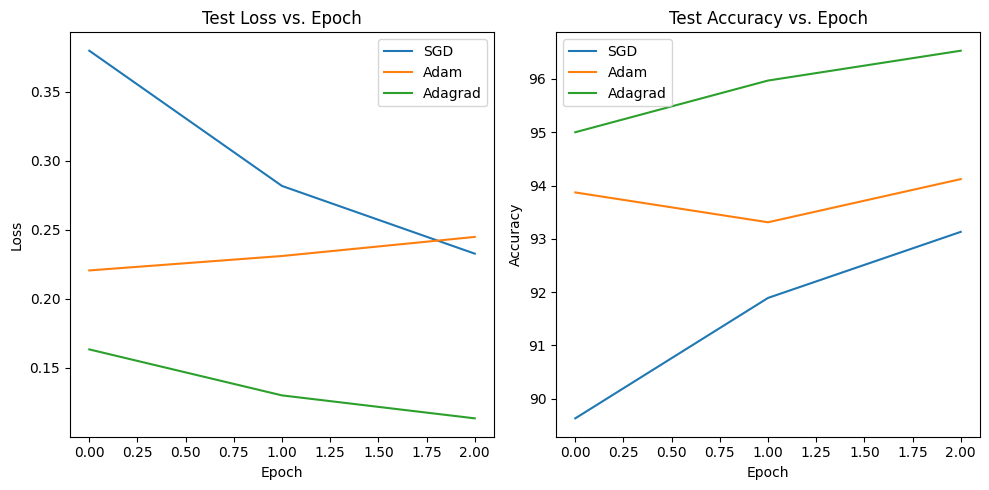

In [2]:
main(lr=None)

Running experiment with different optimizers:

Training with SGD

Epoch 1/3
Epoch: 0, Batch: 100, Loss: 2.126, Accuracy: 34.50%
Epoch: 0, Batch: 200, Loss: 1.574, Accuracy: 46.50%
Epoch: 0, Batch: 300, Loss: 1.078, Accuracy: 53.83%
Epoch: 0, Batch: 400, Loss: 0.833, Accuracy: 59.36%
Epoch: 0, Batch: 500, Loss: 0.709, Accuracy: 63.27%
Epoch: 0, Batch: 600, Loss: 0.652, Accuracy: 66.07%
Epoch: 0, Batch: 700, Loss: 0.571, Accuracy: 68.57%
Epoch: 0, Batch: 800, Loss: 0.537, Accuracy: 70.51%
Epoch: 0, Batch: 900, Loss: 0.510, Accuracy: 72.06%

Test set: Average loss: 0.3626, Accuracy: 9001/10000 (90.01%)


Epoch 2/3
Epoch: 1, Batch: 100, Loss: 0.449, Accuracy: 86.78%
Epoch: 1, Batch: 200, Loss: 0.450, Accuracy: 86.68%
Epoch: 1, Batch: 300, Loss: 0.455, Accuracy: 86.68%
Epoch: 1, Batch: 400, Loss: 0.434, Accuracy: 86.69%
Epoch: 1, Batch: 500, Loss: 0.402, Accuracy: 86.89%
Epoch: 1, Batch: 600, Loss: 0.395, Accuracy: 87.05%
Epoch: 1, Batch: 700, Loss: 0.396, Accuracy: 87.24%
Epoch: 1, Batch: 

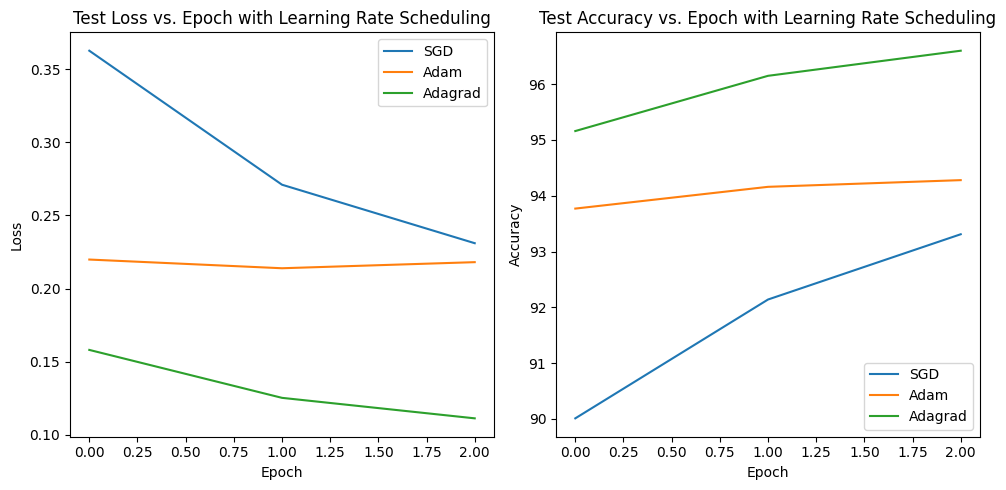

In [3]:
main(lr=True)